In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import norm
from scipy import integrate

In [2]:
file = 'gaia_edr3_selected.csv'
df = pd.read_csv(file)

In [3]:
seed = 9+13+15+28+32+44+45+47

np.random.seed(seed)

x = np.random.randint(0, 100000, 10)

parallax = df.loc[x]['parallax_corr']
error = df.loc[x]['parallax_error']
parallax

3879     0.699477
15829    0.185456
43377   -0.174356
22524    1.581502
17539    0.567943
89941    0.492549
72107    0.350555
17572    0.244145
59121    2.187498
68326   -0.931428
Name: parallax_corr, dtype: float64

In [4]:
error

3879     0.036273
15829    0.054048
43377    0.455253
22524    0.877172
17539    0.178240
89941    0.459871
72107    0.100788
17572    0.045196
59121    0.155611
68326    0.766128
Name: parallax_error, dtype: float64

In [5]:
def likelihood(p, r, sigma):
    return norm.pdf(p,1000/r,sigma)

#Uniform Prior
def Prior_uniform(r, rlim):
    return np.piecewise(r, [r < 0, (r > 0)*(r<rlim), r > rlim], [0, 1/rlim, 0])
    
#     return np.piecewise(r, [r < 0, 0 < r < rlim, r > rlim], [0, 1/rlim, 0])
#Exponential Prior

def Prior_exponential(r, L):
    return r**2*np.exp(-r/L)/Area
######################################################################

def Posterior(r, p, sigma_p, rmin, rlim,prior='Uniform'):
    if prior == 'Uniform':
        return Prior_uniform(r, rlim)*likelihood(p, r, sigma_p)
    elif prior == 'Exp':
        return Prior_exponential(r, 1350)*likelihood(p, r, sigma_p)
    else:
        raise ValueError("Error, hehe")
        
def Cumulative(low, high, AREA, prior):
    return integrate.quad(lambda r: Posterior(r, parallax.iloc[test], error.iloc[test], 0, rlim, prior), low, high)[0]/AREA

error =  0.054047912
parallax =  0.1854555190149817
f_obs =  0.2914332897023886
rlim =  38049.54761431698


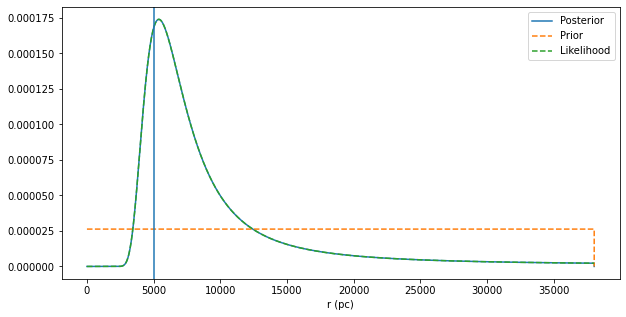

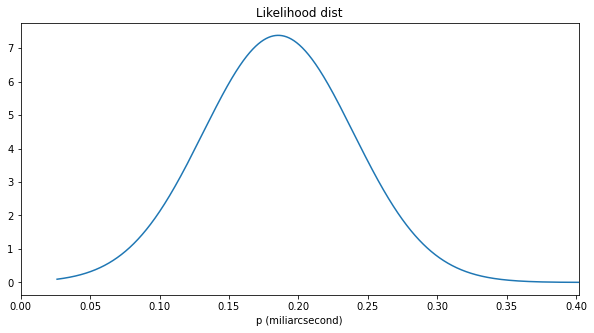

In [6]:
test = 1

########### PLOT
#################### Uniform distance
######################################################################################

resolution = 50000
rlim = 100000
if parallax.iloc[test] - error.iloc[test]> 0:
    rlim = np.min([rlim, 1000/(parallax.iloc[test]-error.iloc[test])*5]) #pc
rmin = 0.1

r = np.linspace(rmin, rlim, resolution)
print('error = ', error.iloc[test])
print('parallax = ', parallax.iloc[test])
print('f_obs = ', error.iloc[test]/parallax.iloc[test])
print('rlim = ', rlim)

#######################################################################################
###############################

Likelihood = likelihood(parallax.iloc[test], r, error.iloc[test])
Area = integrate.simps(Likelihood, r)
Likelihood /= Area    #Normalize the likelihood

Prior = Prior_uniform(r, rlim)

posterior = Posterior(r, parallax.iloc[test], error.iloc[test], rmin, rlim, prior='Uniform')
Area = integrate.simps(posterior, r)
posterior /= Area    #Normalize the posterior

plt.figure(figsize=(10,5))
plt.plot(r, posterior, label='Posterior')
plt.plot(r, Prior, label='Prior', ls='--')
plt.plot(r, Likelihood, label='Likelihood', ls='--')
plt.xlabel('r (pc)')
plt.axvline(5000)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(1000/r, likelihood(1000/r, 1000/parallax.iloc[test], error.iloc[test]))
plt.title('Likelihood dist')
plt.xlabel('p (miliarcsecond)')
plt.xlim(0, parallax.iloc[test]+error.iloc[test]*4)
plt.show()

In [8]:
1000/r


array([1.00000000e+04, 1.16143456e+03, 6.16519640e+02, ...,
       2.62825727e-02, 2.62820471e-02, 2.62815214e-02])

Mean =  9219.079129842297
Mode =  5391.814561239941
Median =  7098.386838653476
upper 90% credible interval =  23292.109858395695
upper 90% credible interval =  4144.313775532293


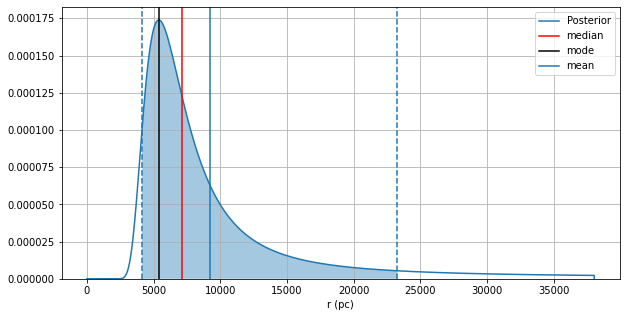

In [9]:
######### MEAN MEDIAN MODE & 90% Credible interval ############
###############################################################
from scipy import stats

AREA = integrate.quad(Posterior, rmin, rlim, args=(parallax.iloc[test], error.iloc[test], 0, rlim, 'Uniform'))[0]

# Mean
mean = integrate.simps(posterior*r,r)
diff = np.abs(r-mean)
mean_index, = np.where(diff==np.min(diff))[0]
mode_index, = np.where(posterior==np.max(posterior))[0]
mode = r[mode_index]

rr = 0
median = rlim
for i in range(10):
    while(rr < median):
        check = Cumulative(rmin, rr, AREA, prior='Uniform')
        if check > 0.5:
            median = rr
        rr += mean/10**i
    rr -= 2*mean/10**i

print('Mean = ', mean)
print('Mode = ', mode)
print('Median = ', median)

alpha = 90

upper = rlim
lower = 0
rr = mode
for i in range(10):
    while(rr < upper):
        CEK = Cumulative(median, rr, AREA, prior='Uniform')
        if CEK > alpha/200:
            upper = rr
        rr += mean/10**i
    rr -= 2*mean/10**i

for i in range(10):
    while(rr > lower):
        CEK = Cumulative(rr, median, AREA, prior='Uniform')
        if CEK > alpha/200:
            lower = rr
        rr -= mean/10**i
    rr += 2*mean/10**i
    
print('upper 90% credible interval = ', upper)
print('upper 90% credible interval = ', lower)

diff = np.abs(r-lower)
lower_index, = np.where(diff==np.min(diff))[0]
diff = np.abs(r-upper)
upper_index, = np.where(diff==np.min(diff))[0]

xbelow = np.max([0, mode-(mode-lower)*2])
xup = np.min([rlim, mode+(upper-mode)*1.1])

plt.figure(figsize=(10,5))
plt.plot(r, posterior, label='Posterior')
# plt.plot(r, prior, label='Prior', ls='--')
# plt.plot(r, Likelihood, label='Likelihood', ls='--')
# plt.axvline(r[7000])
plt.xlabel('r (pc)')
plt.axvline(median, label='median', c='r')
plt.axvline(mode, label='mode', c='k')
plt.axvline(mean, label='mean')
plt.axvline(lower, ls='--')
plt.axvline(upper, ls='--')
plt.legend()
# plt.xlim(xbelow, xup)
plt.ylim(0)
plt.fill_between(r[lower_index:upper_index],posterior[lower_index:upper_index], alpha=0.4)
plt.grid()
plt.show()

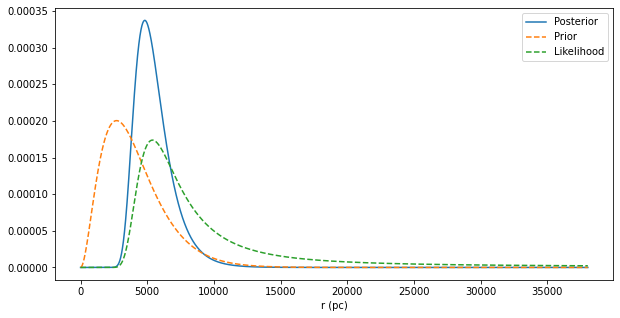

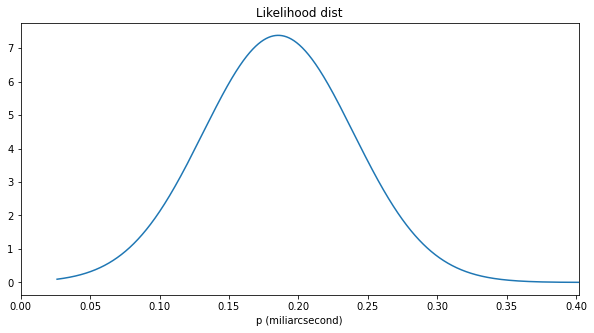

In [10]:
#################### Exponentially Decreasing space density with scale length 1350 pc
######################################################################################

prior = Prior_exponential(r, 1350)
Area = integrate.simps(prior, r)
prior /= Area    #Normalize the prior

posterior = Posterior(r, parallax.iloc[test], error.iloc[test], rmin, rlim, prior='Exp')
Area = integrate.simps(posterior, r)
posterior /= Area    #Normalize the posterior

plt.figure(figsize=(10,5))
plt.plot(r, posterior, label='Posterior')
plt.plot(r, prior, label='Prior', ls='--')
plt.plot(r, Likelihood, label='Likelihood', ls='--')
# plt.axvline(r[7000])
plt.xlabel('r (pc)')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(1000/r, likelihood(1000/r, 1000/parallax.iloc[test], error.iloc[test]))
plt.title('Likelihood dist')
plt.xlabel('p (miliarcsecond)')
plt.xlim(0, parallax.iloc[test]+error.iloc[test]*4)
plt.show()

Mean =  5538.319074042561
Mode =  4818.0174152731215
Median =  5274.577396837798
upper 90% credible interval =  8259.640030870341
upper 90% credible interval =  3713.717298554229


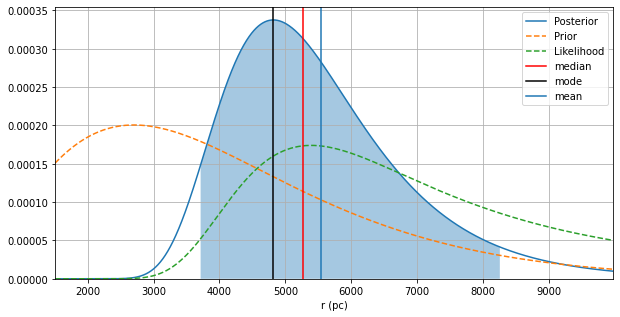

In [11]:
######### MEAN MEDIAN MODE & 90% Credible interval ############
###############################################################
from scipy import stats

AREA = integrate.quad(lambda r: Posterior(r, parallax.iloc[test], error.iloc[test], 0, rlim, 'Exp'), rmin, rlim)[0]

# Mean
mean = integrate.simps(posterior*r,r)
diff = np.abs(r-mean)
mean_index, = np.where(diff==np.min(diff))[0]
mode_index, = np.where(posterior==np.max(posterior))[0]
mode = r[mode_index]

rr = 0
median = rlim
for i in range(10):
    while(rr < median):
        check = Cumulative(rmin, rr, AREA, 'Exp')
        if check > 0.5:
            median = rr
        rr += mean/10**i
    rr -= 2*mean/10**i

print('Mean = ', mean)
print('Mode = ', mode)
print('Median = ', median)

alpha = 90

upper = rlim
lower = 0
rr = mode
for i in range(10):
    while(rr < upper):
        CEK = Cumulative(median, rr, AREA, 'Exp')
        if CEK > alpha/200:
            upper = rr
        rr += mean/10**i
    rr -= 2*mean/10**i

for i in range(10):
    while(rr > lower):
        CEK = Cumulative(rr, median, AREA, 'Exp')
        if CEK > alpha/200:
            lower = rr
        rr -= mean/10**i
    rr += 2*mean/10**i
print('upper 90% credible interval = ', upper)
print('upper 90% credible interval = ', lower)

diff = np.abs(r-lower)
lower_index, = np.where(diff==np.min(diff))[0]
diff = np.abs(r-upper)
upper_index, = np.where(diff==np.min(diff))[0]

xbelow = np.max([0, mode-(mode-lower)*3])
xup = np.min([rlim, mode+(upper-mode)*1.5])

plt.figure(figsize=(10,5))
plt.plot(r, posterior, label='Posterior')
plt.plot(r, prior, label='Prior', ls='--')
plt.plot(r, Likelihood, label='Likelihood', ls='--')
plt.xlabel('r (pc)')
plt.axvline(median, label='median', c='r')
plt.axvline(mode, label='mode', c='k')
plt.axvline(mean, label='mean')
plt.legend()
plt.xlim(xbelow, xup)
plt.ylim(0)
plt.fill_between(r[lower_index:upper_index],posterior[lower_index:upper_index], alpha=0.4)
plt.grid()
plt.show()